<a href="https://colab.research.google.com/github/youngseo21/esaa_22/blob/main/assignment_112522_regression(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **04 사이킷런 LinearRegression을 이용한 보스턴 주택 가격 예측**
____
- 사이킷런의 `linear_models` 모듈은 다양한 종류의 선형 기반 회귀를 클래스로 구현해 제공한다.
- 선형 모델 중 규제가 적용되지 않은 선형 회귀를 사이킷런에서 구현한 `LinearRegression` 클래스를 이용해 보스턴 주택 가격 예측 회귀를 구현한다.

### | **LinearRegression 클래스 - Ordinary Least Squares**
___
- `LinearRegression` 클래스 : 예측값과 실제값의 RSS(Residual Sum of Squares)를 최소화해 OLS(Ordinary Least Squares) 추정 방식으로 구현한 클래스이다.
  + `fit()` 메서드로 X, y 배열을 입력받으면, 회귀 계수(Coefficients)인 W를 `coef_` 속성에 저장한다.
  ```python
  class sklearn.linear_model.LinearRegression(fit_intercept = True, nomalize = False, copy_X = True, n_jobs = 1)
  ```
  + 입력 파라미터
    1. `fit_interceat` : Boolean 값으로, 디폴트는 True. intercept(절편)을 계산할 것인지 말 것인지를 지정한다. False이면, intercept가 계산되지 않고, 0으로 지정된다.
    2. `normalize` : Boolean 값으로, 디폴트는 False. `fit_intercept = False`인 경우, 이 파라미터는 무시된다. 만일 True이면 회귀를 수행하기 전, 입력 데이터셋을 정규화한다.
  + 속성
    1. `coef_` : `fit()` 메서드를 수행했을 때 회귀 계수가 배열 형태로 저장된 속성. Shape는 (Target 값 개수, Feature 개수)
    2. `intercept_` : intercept 값
- OLS 기반의 회귀 계수 계산은 입력 Feature의 독립성에 많은 영향을 받는다. Feature 간의 상관관계가 높으면 분산이 매우 커져, 오류에 매우 민감해진다. 이를 **다중 공선성(multi-collinearity)** 문제라고 한다.
  + 독립적이며 중요한 Feature만 남기고 제거하거나 규제를 적용한다.
  + 다중 공선성 문제를 가지고 있는 Feature가 많다면, PCA를 통해 차원 축소를 수행할 수도 있따.

### | **회귀 평가 지표**
___
- 회귀의 평가를 위한 지표는 실제 값과 회귀 예측값의 차이를 기반으로 한다. 
- 실제값과 예측값의 차이를 그냥 더하면 오류가 0이 되기 때문에, 오류의 절댓값의 평균이나 제곱, 또는 제곱한 뒤 다시 루트를 씌운 평균값을 지표로 사용한다.
- 회귀의 성능을 평가하는 지표
  1. MAE(Mean Absolute Error) : 오차에 절댓값을 씌운 후, 평균을 구한 것
  $$MAE = \frac{1}{n} \sum_{i=1}^{n} |Y_i - \hat{Y}_i|$$
  2. MSE(Mean Squared Error) : 오차를 제곱해 평균을 구한 것
  $$MSE = \frac{1}{n} \sum_{i=1}^{n} ( Y_i - \hat{Y}_i) ^2$$
  3. RMSE(Root Mean Squared Error) : MSE 값은 실제 오류 평균보다 더 커지는 경향이 있어, MSE에 루트를 씌운 RSME를 사용하기도 한다.
  $$RMSE = \sqrt{\frac{1}{n} \sum_{i=1}^{n} ( Y_i - \hat{Y}_i) ^2}$$
  4. R$^2$ : 분산 기반으로 예측 성능을 평가한다. 실제 값의 분산 대비 예측 값의 분산 비율을 지표로 하며, 1에 가까울수록 예측 정확도가 높다.(Y의 총변동량 중 모델이 설명하는 변동량의 비율)
  $$R^2 = \frac{예측값의 Variance}{실제값 Variance}$$
  + 이 밖에 MSE나 RMSE에 로그를 적용한 MSLE(Mean Squared Log Error)와 RMSLE(Root Mean Squared Log Error)도 사용한다.
- 사이킷런의 API 및 `cross_val_score`이나, GridSearchCV에서 평가 시 사용하는 `scoring` 파라미터 적용 값

|평가 방법|사이킷런 평가 지표 AP|`scoring` 파라미터 적용 값|
|---|---|---|
|MAE|`metrics.mean_absolute_error`|'neg_mean_absolute_error'|
|MSE|`metrics.mean_squared_error`|'neg_mean_squared_error'|
|$R^2$|`metrics.r2_score`|'r2'|

  + MAE의 `scoring` 파라미터 적용 값을 보면 'neg_mean_absolute_error'로, 'neg_'라는 접두사를 가지고 있다. 이는 Negative 값(음수)을 가진다는 의미인데, MAE는 절댓값의 합이므로 음수가 될 수 없다.
  + 사이킷런의 Scoring 함수가 score 값이 클수록 좋은 평가를 하는데, 회귀에서 score값이 크다는 것은 오류가 큰 나쁜 모델이라는 의미이기 때문에, 이를 보정하기 위해 음수값을 반환한다.
  + 즉, Scoring 함수의 scoring 파라미터 값 'neg_mean_absolute_error'가 의미하는 것은 -1*`metrics.mean_absolute_error()`이다.
- 사이킷런은 RMSE를 제공하지 않는다. MSE를 구한 후, MSE에 제곱근을 씌워 직접 계산해줘야 한다.

### | **LinearRegression을 이용해 보스턴 주택 가격 회귀 구현**
___
- 사이킷런에 내장된 보스턴 주택 가격 데이터를 이용한다.
- Feature 설명
  - CRIM: 지역별 범죄 발생률
  - ZN: 25000 평방 피트를 초과하는 거주 지역의 비율
  - INDUS: 비상업 지역 넓이 비율 
  - CHAS: 찰스강에 대한 더미 변수(강의 경계에 위치한 경우 1, 아니면 0)
  - NOX: 일산화질소 농도
  - RM: 거주할 수 있는 방 개수
  - AGE: 1940년 이전에 건축된 소유 주택의 비율
  - DIS: 5개 주요 고용센터까지의 가중 거리
  - RAD: 고속도로 접근 용이도 
  - TAX: 10000 달러당 재산세율
  - PTRATIO: 지역의 교사와 학생 수 비율
  - B: 지역의 흑인 거주 비율
  - LSTAT: 하위 계층의 비율
  - MEDV: 본인 소유의 주택 가격(중앙값)

- 사이킷런은 보스턴 주택 가격데이터셋을 `load_boston()`을 통해 제공한다. 해당 데이터셋을 로드한 후, DataFrame으로 변경하자.

In [1]:
# import package
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.datasets import load_boston
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
# boston 데이터셋 로드
boston = load_boston()

# boston 데이터셋을 DataFrame으로 변환 
bostonDF = pd.DataFrame(boston.data , columns = boston.feature_names)

# boston dataset의 target 배열은 주택 가격
# 이를 PRICE 컬럼으로 DataFrame에 추가 
bostonDF['PRICE'] = boston.target
print('Boston 데이터셋 크기 :', bostonDF.shape)
bostonDF.head()

Boston 데이터셋 크기 : (506, 14)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [4]:
# Null 값 및 자료형 확인
bostonDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    float64
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  PRICE    506 non-null    float64
dtypes: float64(14)
memory usage: 55.5 KB


- 데이터셋 Feature의 Null 값음 없으며, 모두 float 형이다.
- 각 Column이 회귀 결과에 미치는 영향이 어느정도인지 시각화해서 알아본다.
  + Seaborn의 `regplot()` API는 X, Y 축 값의 산점도와 함께 선형 회귀 직선을 그려준다.
  + `matplotlib.subplots()`를 이용해 각 ax마다 Column과 PRICE의 관계를 표현한다.
    - `matplotlib.subplots()`은 여러 개의 그래프를 한 번에 표현하기 위해 자주 사용한다.
    
    - 
    ```python
plt.subplots(ncols = 'Row 방향으로 위치할 그래프의 개수', nrows = 'Column 방향으로 위치할 그래프의 개수') 
```


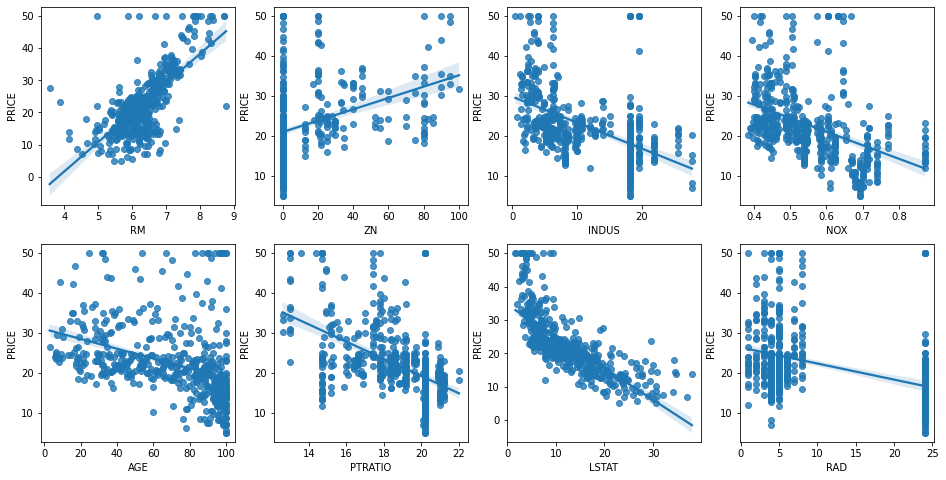

In [5]:
# 2개의 행과 4개의 열을 가진 subplots를 이용
# axs는 4x2개의 ax를 가짐
fig, axs = plt.subplots(figsize = (16,8) , ncols = 4 , nrows = 2)
lm_features = ['RM','ZN','INDUS','NOX','AGE','PTRATIO','LSTAT','RAD']

for i , feature in enumerate(lm_features):
    row = int(i/4)
    col = i%4
    # 시본의 regplot을 이용해 산점도와 선형 회귀 직선을 함께 표현
    sns.regplot(x = feature , y='PRICE', data = bostonDF , ax = axs[row][col])

- 다른 Column보다 RM과 LSTAT가 PRICE에 큰 영향을 주고 있다.
  + RM(방 개수)은 Positive Linearity가 가장 크다. 즉, 방의 크기가 클수록 가격이 증가한다.
  + LSTAT(하위 계층의 비율)은 Negative Linearity가 가장 크다. 즉, LSTAT이 적을수록 가격이 증가한다.
- 이제 `LinearRegression` 클래스를 이용해 보스턴 주택 가격의 회귀 모델을 만든다.
- `train_test_split()`을 이용해 학습과 테스트 데이터셋을 분리해 학습과 예측을 수행한다.
- 그리고 `metrics` 모듈의 `mean_squared_error()`와 `r2_score()` API를 이용해 MSE와 $R^2$를 측정한다.

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error , r2_score

y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'],axis = 1,inplace = False)

X_train , X_test , y_train , y_test = train_test_split(X_data , y_target ,test_size=0.3, random_state=156)

In [7]:
# Linear Regression OLS로 학습/예측/평가 수행
lr = LinearRegression()
lr.fit(X_train ,y_train)
y_preds = lr.predict(X_test)
mse = mean_squared_error(y_test, y_preds)
rmse = np.sqrt(mse)

print('MSE : {0:.3f}, RMSE : {1:.3F}'.format(mse , rmse))
print('Variance score : {0:.3f}'.format(r2_score(y_test, y_preds)))

MSE : 17.297, RMSE : 4.159
Variance score : 0.757


- `LinearRegression`으로 생성한 주택 가격 모델의 intercept과 coefficients 값을 살펴본다. 각각 `LinearRegression` 객체의 `intercept_` 속성과 `coef_` 속성에 저장되어 있따.

In [8]:
print('절편 값 : ', lr.intercept_)
print('회귀 계수값 : ', np.round(lr.coef_, 1))

절편 값 :  40.99559517216477
회귀 계수값 :  [ -0.1   0.1   0.    3.  -19.8   3.4   0.   -1.7   0.4  -0.   -0.9   0.
  -0.6]


- `coef_` 속성에 저장되어 있는 회귀 계수 값을 Feature 별 회귀 계수 값으로 다시 mapping 한 후, 높은 값 순으로 출력해보자. Pandas Series의 `sort_value()` 함수를 이용한다.

In [9]:
# 회귀 계수를 Series로 변환
# index Column 명에 유의
coeff = pd.Series(data = np.round(lr.coef_, 1), index = X_data.columns )

# 큰 값 순으로 정렬
coeff.sort_values(ascending = False)

RM          3.4
CHAS        3.0
RAD         0.4
ZN          0.1
INDUS       0.0
AGE         0.0
TAX        -0.0
B           0.0
CRIM       -0.1
LSTAT      -0.6
PTRATIO    -0.9
DIS        -1.7
NOX       -19.8
dtype: float64

- RM이 3.4로 회귀 계수가 가장 크다.
- NOX의 회귀 계수 값이 -19.8으로 음수 값이 너무 크다.
- 이번에는 5개의 폴드 세트에서 `cross_val_score()`를 이용해 교차 검증으로 MSE와 RMSE를 측정해보자. 이때 RMSE는 MSE 값을 이용하여 계산해야 한다.

In [10]:
from sklearn.model_selection import cross_val_score

y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'],axis = 1,inplace = False)
lr = LinearRegression()

# cross_val_score()로 5개의 폴드 세트로 MSE 를 구한 뒤, 이를 기반으로 다시 RMSE 구함 
neg_mse_scores = cross_val_score(lr, X_data, y_target, scoring="neg_mean_squared_error", cv = 5)

# 음수 값이므로 -1을 곱하여 계산
rmse_scores  = np.sqrt(-1 * neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

# cross_val_score(scoring="neg_mean_squared_error")로 반환된 값은 모두 음수 
print(' 5 folds 의 개별 Negative MSE scores : ', np.round(neg_mse_scores, 2))
print(' 5 folds 의 개별 RMSE scores : ', np.round(rmse_scores, 2))
print(' 5 folds 의 평균 RMSE : {0:.3f}'.format(avg_rmse))

 5 folds 의 개별 Negative MSE scores :  [-12.46 -26.05 -33.07 -80.76 -33.31]
 5 folds 의 개별 RMSE scores :  [3.53 5.1  5.75 8.99 5.77]
 5 folds 의 평균 RMSE : 5.829
